# Neural networks for predicting ethnicity from surnames

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
memorial_data = pd.read_csv('./MemorialData/memorial_data_final.csv')

In [6]:
memorial_data.ethnicity_col = memorial_data.ethnicity_col.astype('category')
y = memorial_data.ethnicity_col.cat.codes

### Hyperparameters

In [7]:
maxlen = 50
training_samples = 750000
validation_samples = 250000
embedding_dim = 100
NGRAMS = 2
#SAMPLE = 1000000
EPOCHS = 15
batch_size = 32
feature_len = 18

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(memorial_data.surn)
vocab = vect.vocabulary_

In [7]:
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(memorial_data.surn.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_name_len = max(X_len)
avg_name_len = int(np.mean(X_len))

print("Max (sur)name len = %d, Avg. (sur)name len = %d" % (max_name_len, avg_name_len))
#y = np.array(sdf.race.astype('category').cat.codes)

num_words = 1522
Max (sur)name len = 44, Avg. (sur)name len = 6


In [8]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

print('Pad sequences (samples x time)')
X_train = pad_sequences(X_train, maxlen=feature_len)
X_test = pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


Pad sequences (samples x time)
X_train shape: (971636, 18)
X_test shape: (242909, 18)
11 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (971636, 11)
y_test shape: (242909, 11)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
model.add(Embedding(num_words, 32, input_length=feature_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 18, 32)            48704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1419      
Total params: 132,555
Trainable params: 132,555
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=5,
          validation_split=0.1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 874472 samples, validate on 97164 samples
Epoch 1/5
874472/874472 [==============================] - 2229s 3ms/sample - loss: 0.5654 - accuracy: 0.8060 - val_loss: 0.5045 - val_accuracy: 0.8280
Epoch 2/5
874472/874472 [==============================] - 1965s 2ms/sample - loss: 0.4970 - accuracy: 0.8300 - val_loss: 0.4708 - val_accuracy: 0.8402
Epoch 3/5
874472/874472 [==============================] - 2149s 2ms/sample - loss: 0.4762 - accuracy: 0.8375 - val_loss: 0.4584 - val_accuracy: 0.8445
Epoch 4/5
874472/874472 [==============================] - 2418s 3ms/sample - loss: 0.4655 - accuracy: 0.8413 - val_loss: 0.4481 - val_accuracy: 0.8480
Epoch 5/5
242909/242909 [==============================] - 265s 1ms/sample - loss: 0.4368 - accuracy: 0.8518
Test score: 0.4368469234790005
Test accuracy: 0.8517511


In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test, verbose=2)
target_names = list(memorial_data.ethnicity_col.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


242909/242909 - 220s


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         altai       0.71      0.05      0.09       408
        armyan       0.85      0.65      0.74       678
         georg       0.85      0.79      0.82       343
        jewish       0.76      0.30      0.43      6938
kabard_cherkes       0.68      0.48      0.56      1246
        mongol       0.79      0.55      0.65      2232
      no match       0.77      0.67      0.71     50091
        osetin       0.68      0.33      0.44       667
        slavic       0.87      0.94      0.91    153968
    turkic_all       0.88      0.90      0.89     26147
        vainah       0.00      0.00      0.00       191

      accuracy                           0.85    242909
     macro avg       0.71      0.51      0.57    242909
  weighted avg       0.85      0.85      0.84    242909



C:\Users\Martin\Desktop\skola\CERGE\PV_Names\confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Martin\Desktop\skola\CERGE\PV_Names\confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\Martin\Desktop\skola\CERGE\PV_Names\confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Martin\Desktop\skola\CERGE\PV_Names\confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible inste

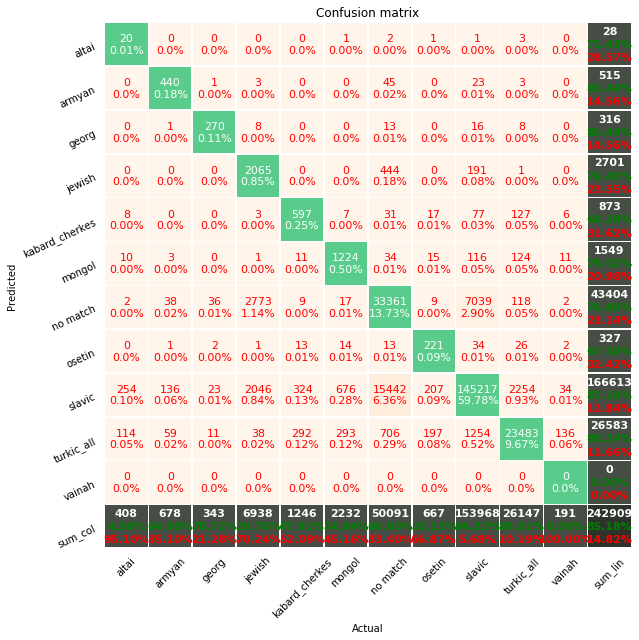

In [29]:
import os
os.chdir("C:/Users/Martin/Desktop/skola/CERGE/PV_Names/")
import confusion_matrix_pretty_print as cm
cm.plot_confusion_matrix_from_data(np.argmax(y_test, axis=1), y_pred, columns=target_names, figsize=[32, 32], fz=13)

The same problem with overpredicting slavic ethnicity.

In [30]:
model.save('ethnicity_pred_lstm_model.h5')

In [31]:
#words_df = pd.DataFrame(words_list, columns=['vocab'])
#words_df.to_csv('C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/lstm_model_vocab.csv', index=False, encoding='utf-8')


In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

model = load_model('ethnicity_pred_lstm_model.h5')


In [22]:
y_pred = model.predict_classes(X_test, verbose=2)
target_names = list(memorial_data.ethnicity_col.astype('category').cat.categories)


242909/242909 - 191s


In [24]:
X_test

array([[  0,   0,   0, ...,   5, 388, 240],
       [  0,   0,   0, ..., 332, 224,   2],
       [  0,   0,   0, ...,   0,   5,  34],
       ...,
       [  0,   0,   0, ..., 110, 268, 360],
       [  0,   0,   0, ..., 208,  43,   0],
       [  0,   0,   0, ...,   8,  19,   2]])

In [ ]:
nb_mis_cals_names = X_test[(y_pred_cal == target_names.index('slavic')) & (y_test != target_names.index('slavic'))].rename("surn")
nb_mis_cals_names.to_frame().groupby('surn').size().reset_index(name='counts').sort_values("counts", ascending=False).query('counts > 10').to_csv('./MemorialData/misclas_as_slavic_oversampl_nb.csv')

In [3]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(X, y, test_size=0.2, random_state=21, stratify=y)

ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            71520     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 38)                4902      
Total params: 158,854
Trainable params: 158,854
Non-trainable params: 0
_________________________________________________________________
